# Understanding Flow Matching Models: Let's Build One!

> aka flow-guessing models

Ever wonder how we can teach a neural network to transform one type of data into another? Like turning noise into images (which is what diffusion models do), or morphing one distribution into another? That's what flow models are all about!

### The Basic Idea
Think about watching clouds move and change shape in the sky. If you could track every water droplet, you'd see them all following certain patterns or "flows" as they move. Flow models work kind of like that - they learn how to move points from one distribution to another by following specific paths or "flows".

Let's start by importing what we need and creating some visualization tools.


In [1]:
# Tell matplotlib to display plots inline in the no|tebook
%matplotlib inline  

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display

In [62]:
# Define helper functions, generating points and plotting 

# A few different data distributions
def create_gaussian_data(n_points=1000, scale=1.0):
    """Create a 2D Gaussian distribution"""
    return torch.randn(n_points, 2) * scale

def create_square_data(n_points=1000, scale=1.0):
    """Create points uniformly distributed in a square"""
    # Generate uniform points in a square
    points = (torch.rand(n_points, 2) * 2 - 1) * scale
    return points

def create_spiral_data2(n_points=1000, scale=1.0):
    """Create a spiral distribution"""
    noise = 0.1*scale 
    theta = torch.linspace(0, 6*np.pi, n_points)
    r = theta / (2*np.pi)
    x = r * torch.cos(theta) + noise * torch.randn(n_points)
    y = r * torch.sin(theta) + noise * torch.randn(n_points)
    return torch.stack([x, y], dim=1)


# Generate target data in the shape of a spiral
def create_spiral_data(n_points, scale=1.0):
    theta = np.linspace(0, 4 * np.pi, n_points)
    r = np.linspace(0, 1, n_points)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    spiral_data = np.stack((x, y), axis=1)
    return torch.tensor(spiral_data, dtype=torch.float32)
    

def create_heart_shaped_data(n_points=1000, scale=1.0):
    """Create a heart-shaped distribution of points"""
    # Generate points within a square
    square_points = create_square_data(n_points, scale)
    
    # Calculate the heart-shaped condition for each point
    x, y = square_points[:, 0], square_points[:, 1]
    heart_condition = x**2 + ((5 * (y + 0.25) / 4) - torch.sqrt(torch.abs(x)))**2 <= 1
    
    # Filter out points that don't satisfy the heart-shaped condition
    heart_points = square_points[heart_condition]
    
    # If we don't have enough points, generate more
    while len(heart_points) < n_points:
        new_points = create_square_data(n_points - len(heart_points), scale)
        x, y = new_points[:, 0], new_points[:, 1]
        new_heart_condition = x**2 + ((5 * (y + 0.25) / 4) - torch.sqrt(torch.abs(x)))**2 <= 1
        new_heart_points = new_points[new_heart_condition]
        heart_points = torch.cat([heart_points, new_heart_points], dim=0)
    
    return heart_points[:n_points]

def create_two_gaussians(n_points=1000, scale=1.0):
    """Create a 2D Gaussian distribution"""
    g  = torch.randn(n_points, 2) * scale
    g[:n_points//2,0] -= 3
    g[n_points//2:,0] += 3
    return g




# A couple aliases so we can easily switch distributions without affecting later code 
def create_source_data(n_points=1000, scale=1.0, gen_fn=create_gaussian_data):
    return gen_fn(n_points=n_points, scale=scale)
    
def create_target_data(n_points=1000, scale=1.0, gen_fn=create_spiral_data2):
    return gen_fn(n_points=n_points, scale=scale)





def plot_distributions(dist1, dist2, title1="Distribution 1", title2="Distribution 2"):
    """Plot two distributions side by side"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.scatter(dist1[:, 0], dist1[:, 1], alpha=0.6, s=10, c='r')
    ax2.scatter(dist2[:, 0], dist2[:, 1], alpha=0.6, s=10, c='r')
    
    ax1.set_title(title1)
    ax2.set_title(title2)
    
    # Set same scale for both plots
    max_range = max(
        abs(dist1).max().item(),
        abs(dist2).max().item()
    )
    for ax in [ax1, ax2]:
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()  # Explicitly show the plot


def create_flow_animation(start_dist, end_dist, figsize=(5, 5), n_frames=100):
    """Create an animation showing distribution flow"""
    fig, ax = plt.subplots(figsize=figsize)
    plt.close()  # Close the figure immediately
    
    max_range = max(
        abs(start_dist).max().item(),
        abs(end_dist).max().item()
    )
    ax.set_xlim((-max_range, max_range))
    ax.set_ylim((-max_range, max_range))
    ax.set_aspect('equal')
    
    scatter = ax.scatter([], [], alpha=0.6, s=10, c='r')
    
    def init():
        scatter.set_offsets(np.c_[[], []])
        return (scatter,)
    
    def animate(frame):
        t = frame / (n_frames - 1)
        current = start_dist * (1-t) + end_dist * t
        scatter.set_offsets(current.numpy())
        return (scatter,)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=n_frames, interval=20, blit=True)
    
    rc('animation', html='jshtml')
    return HTML(anim.to_jshtml())


def show_flow_sequence(start_dist, end_dist, n_steps=5):
    """Show the flow as a sequence of static plots"""
    fig, axes = plt.subplots(1, n_steps, figsize=(4*n_steps, 4))
    
    max_range = max(
        abs(start_dist).max().item(),
        abs(end_dist).max().item()
    )
    
    for i, ax in enumerate(axes):
        t = i / (n_steps - 1)
        current = start_dist * (1-t) + end_dist * t
        
        ax.scatter(current[:, 0], current[:, 1], alpha=0.6, s=10, c='r')
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        ax.set_aspect('equal')
        ax.set_title(f't = {t:.2f}')
    
    plt.tight_layout()
    plt.show()  # Explicitly show the plot

Now let's see these visualization tools in action! We'll create two different distributions and see how points might flow between them:

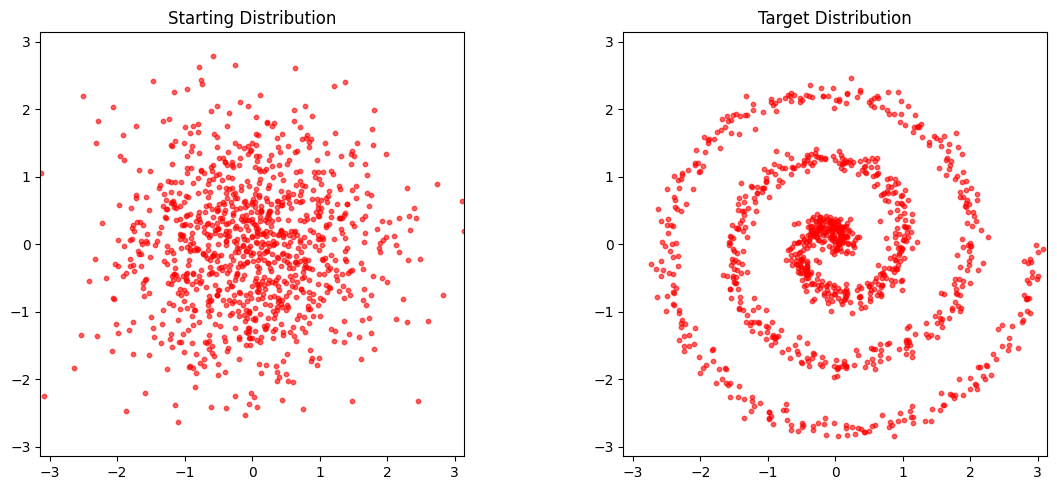

In [63]:
# Create our distributions
n_points = 1000
source = create_source_data(n_points)
target = create_target_data(n_points)

# Clear any existing plots
plt.close('all')
# Show the start and end distributions
plot_distributions(source, target, "Starting Distribution", "Target Distribution")

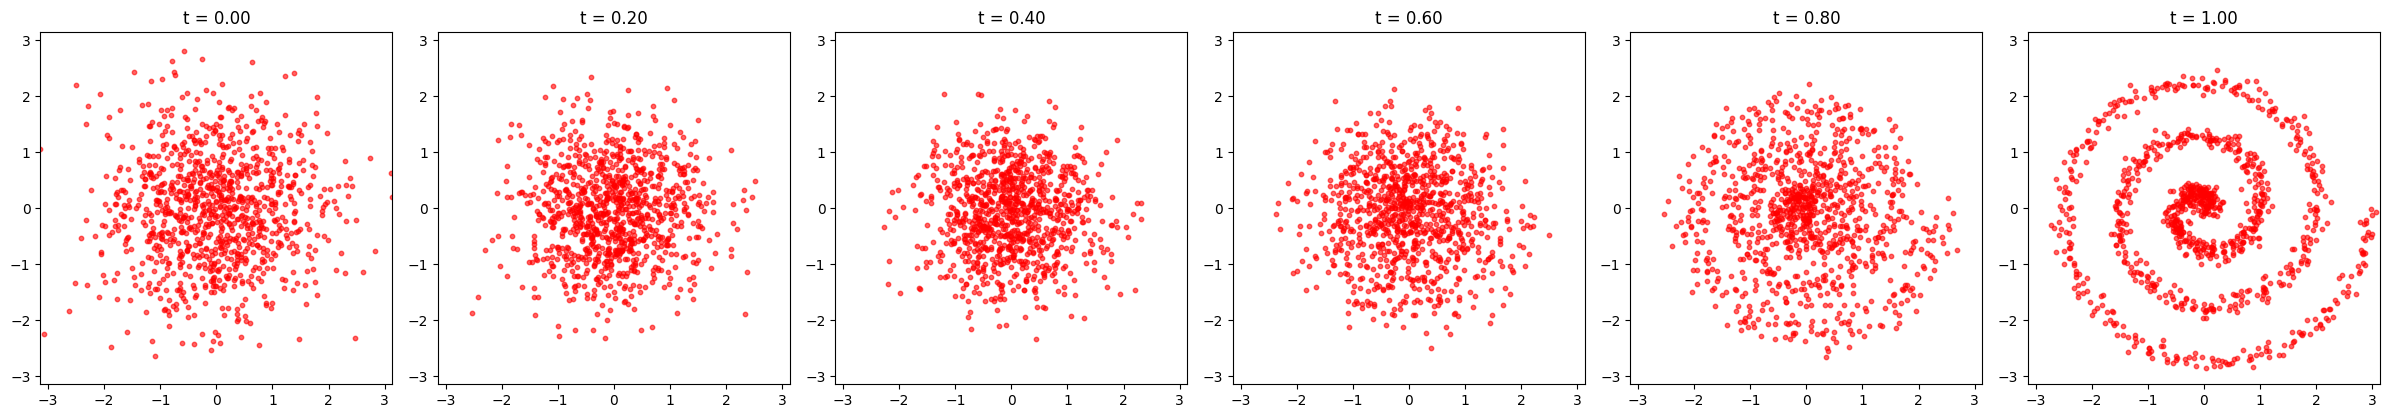

In [64]:
# Show the flow sequence
show_flow_sequence(source, target, n_steps=6)

And here (hopefully!) is an animation:

In [66]:
# Uncomment the next line to generate the animation yourself  (it makes the notebook file too big to include by default)
#display(create_flow_animation(source, target))

( **WARNING: That was all "fake"!** No *actual* models have been trained yet.  ) 

What you're seeing above is just a simple linear interpolation - each point is taking the straightest possible path from its start position to its end position. But real distributions don't usually transform this way! In nature and in many real-world processes, points often follow curved paths or more complex trajectories.

That's where flow models come in. Instead of just moving points in straight lines, they learn the actual paths or "flows" that points should follow to transform one distribution into another. This is especially useful when we're dealing with complex data like images, where we want smooth, natural transformations.

### How is all this different from diffusion models?
If you're familiar with diffusion models (which we covered in an earlier tutorial), you might be wondering how this is different. Here's the key distinction:

- Diffusion models gradually add random noise to data, then learn to reverse that process
- Flow models learn direct transformations between distributions without adding randomness
- Diffusion is like slowly dissolving an image in acid and learning to un-dissolve it
- Flows are like learning the exact choreography of how every point should move

In the next section, we'll start building our own flow model, piece by piece. But first - any questions about the basic concept?

## The Core Mechanism: Flow Matching

Remember how we showed points moving in straight lines between distributions? While that looked nice, it's not very realistic. In the real world, things typically follow curved paths - like water flowing in a river, or crowds of people navigating around obstacles.

Flow matching learns these natural paths by focusing on the *velocity* at each point - essentially asking "which way should each point be moving at this moment?"

Let's visualize this idea with vector fields. A vector field is like a map that shows which way things should move at each point in space. Think of it like:
- A weather map showing wind directions
- Water flowing around rocks in a stream
- A crowd of people moving through a busy plaza


In [67]:
# Define plotting routines for vector / flow visualization
def plot_vector_field(points, vectors, title="Vector Field", density=20):
    """Plot points and their associated velocity vectors"""
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot the points
    ax.scatter(points[:, 0], points[:, 1], alpha=0.3, s=10, label='Points',c='r')
    
    # Create a grid for the vector field
    max_range = abs(points).max().item() * 1.2
    x = np.linspace(-max_range, max_range, density)
    y = np.linspace(-max_range, max_range, density)
    X, Y = np.meshgrid(x, y)
    
    # Plot the vectors
    ax.quiver(points[:, 0], points[:, 1], 
             vectors[:, 0], vectors[:, 1],
             alpha=0.5, label='Velocities')
    
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()


# Create a rotational vector field
def rotational_field(points):
    """Create vectors that rotate around the origin"""
    vectors = torch.zeros_like(points)
    vectors[:, 0] = -points[:, 1]  # x component
    vectors[:, 1] = points[:, 0]   # y component
    return vectors / (torch.norm(points, dim=1, keepdim=True) + 1e-5)

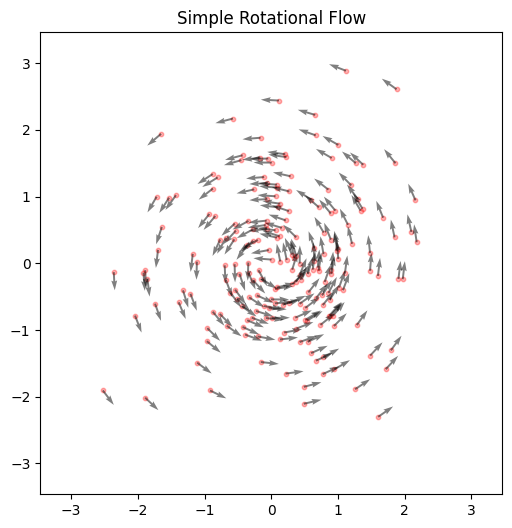

In [68]:
# Example: Simple Rotational Flow
n_points = 200
points = create_source_data(n_points, scale=1.0)
vectors = rotational_field(points)
plot_vector_field(points, vectors, "Simple Rotational Flow")

### The Big Idea
The key insight of flow matching is:

> Instead of learning to directly transform point A into point B, we learn the *velocity* each point should have at each moment. These velocities form a vector field that guides points along their paths. Following these velocities moves points from the source to target distribution.

Think of it like teaching someone to ride a bike. Instead of saying "be at point B in 5 minutes", we give them continuous guidance: "lean right a bit here", "pedal harder there", etc. The vector field is like these continuous instructions for how to move.


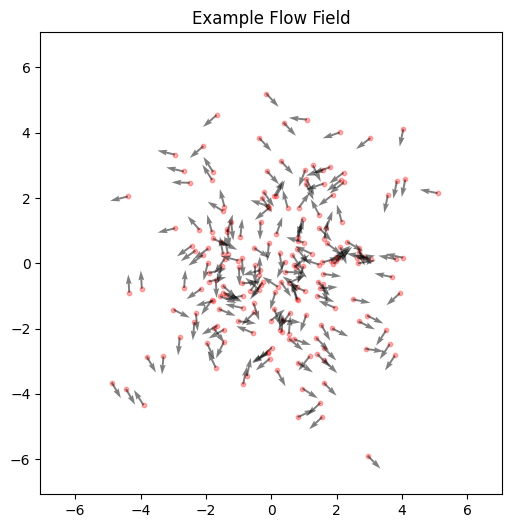

In [69]:
# code for another sample flow field plot
def flow_direction(points, source, target):
    """Compute the direction points should move to transform source -> target"""
    # For this simple example, we'll just point directly toward the target
    # (In reality, we'll learn a more sophisticated vector field)
    vectors = torch.zeros_like(points)
    for i, p in enumerate(points):
        # Find nearest source and target points
        dist_to_source = torch.norm(source - p.unsqueeze(0), dim=1)
        dist_to_target = torch.norm(target - p.unsqueeze(0), dim=1)
        
        nearest_source = source[dist_to_source.argmin()]
        nearest_target = target[dist_to_target.argmin()]
        
        # Vector pointing from source to target
        vectors[i] = (nearest_target - nearest_source)
        
    return vectors / (torch.norm(vectors, dim=1, keepdim=True) + 1e-5)

# Create example flow
n_points = 200
grid_points = create_source_data(n_points, scale=2.0)  # Points to show vectors at
source = create_source_data(n_points)
target = create_target_data(n_points)

vectors = flow_direction(grid_points, source, target)
plot_vector_field(grid_points, vectors, "Example Flow Field")


This is just a simple example of a vector field - it naively points directly from source to target positions. In practice, we'll train a neural network to learn much smoother and more natural vector fields.

Next, we'll implement the actual flow matching mechanism and train it to learn these vector fields. The cool part is that once we have a good vector field, we can start from *any* point and follow the flow to reach our target distribution!

### An Important Question

Before we continue, let's address a crucial question that helps understand what flow matching is really doing:

**Q: Is the model learning to transform the points themselves (e.g. points in A to points in B), or to transform the *probability distribution* of the points in A to the probability distribution of points in B?**

The model is learning to transform the probability distributions, not specific point-to-point mappings. This is a key distinction! Rather than learning "point x₁ should move to point y₁", it's learning "what movement would make the shape of distribution A gradually morph into the shape of distribution B?"

Think of it like this: If you have a cloud of smoke in the shape of a square and want it to form the shape of a circle, you don't need to track each smoke particle's destination - you just need to know how the overall shape should flow to achieve the desired form.

In fact, this is one of the main advantages of flow matching: it learns a smooth, continuous transformation of the entire probability space. The vector field tells us:
- For ANY point in space (not just points in our training data)
- At ANY time during the transformation (from t=0 to t=1)
- Which direction that point should move

One possible analogy: Think of it like learning the rules of a river's flow rather than tracking individual water molecules.

## Learning the Flow: How Does it Actually Work?

Now that we understand we're transforming probability distributions, let's see how flow matching actually learns to do this. The key idea breaks down into three parts:

> For any point in space and any time t between 0 and 1, we want to learn the correct *velocity* (direction and speed) that point should move. These velocities should gradually transform our starting distribution into our target distribution

It's like learning a "wind map" that will blow the starting distribution cloud into the shape of the target distribution cloud. 


In [70]:
import torch.nn as nn

# Simple neural network that will predict velocities
class VelocityNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        # Input: point coordinates (2) and time (1)
        self.net = nn.Sequential(
            nn.Linear(2 + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Output: velocity vector (2)
        )
    
    def forward(self, x, t):
        # x: point coordinates, t: time
        xt = torch.cat([x, t.reshape(-1, 1)], dim=1)
        return self.net(xt)

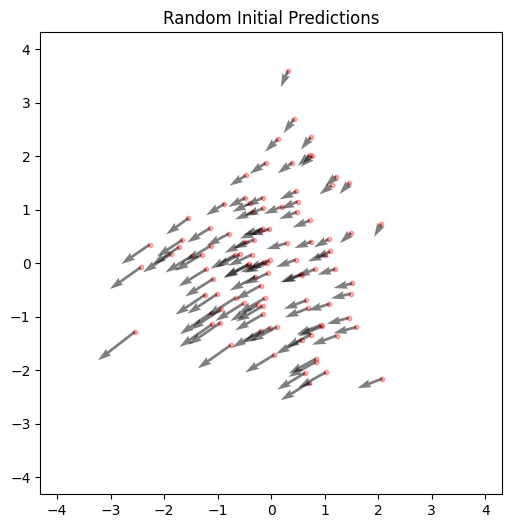

In [71]:
# Let's visualize what the untrained network predicts
model = VelocityNet()
# Sample some points and times
x = torch.randn(100, 2)  # 100 random points
t = torch.ones(100) * 0.5  # all at t=0.5

# Get predicted velocities
with torch.no_grad():
    velocities = model(x, t)

# Plot the points and their predicted velocities
plot_vector_field(x, velocities, "Random Initial Predictions")


The clever part about flow matching is how we train this network. For each training step:

1. Sample random points from our source distribution
2. Sample random time points between 0 and 1
3. Calculate where these points *should* be at those times (we'll see how in a moment)
4. Calculate what velocity they *should* have at those times
5. Train the network to predict these velocities

Let's implement this step by step...

### Generating Training Data

💡 Here's a key insight: if we know our starting point (from source distribution) and ending point (from target distribution), 
we can figure out what the velocity should be at any time t along the path.

The simplest way (though not the only way) is to assume points move in straight lines from source to target. Even though 
our network might learn more complex paths later, this gives us a starting point for training.


In [72]:
def generate_training_batch(n_samples=1000):
   """Generate a batch of training data"""
   # Sample from source and target distributions
   source_samples = create_source_data(n_samples)
   target_samples = create_target_data(n_samples)
   
   # Sample random time points
   times = torch.rand(n_samples)
   
   # For straight-line paths:
   # Position at time t is a linear interpolation
   current_points = source_samples * (1 - times.reshape(-1, 1)) + target_samples * times.reshape(-1, 1)
   
   # Target velocity is difference between target and source
   # (This is the simplest choice - more sophisticated choices exist!)
   target_velocities = target_samples - source_samples
   
   return current_points, times, target_velocities


Let's visualize what we just created:

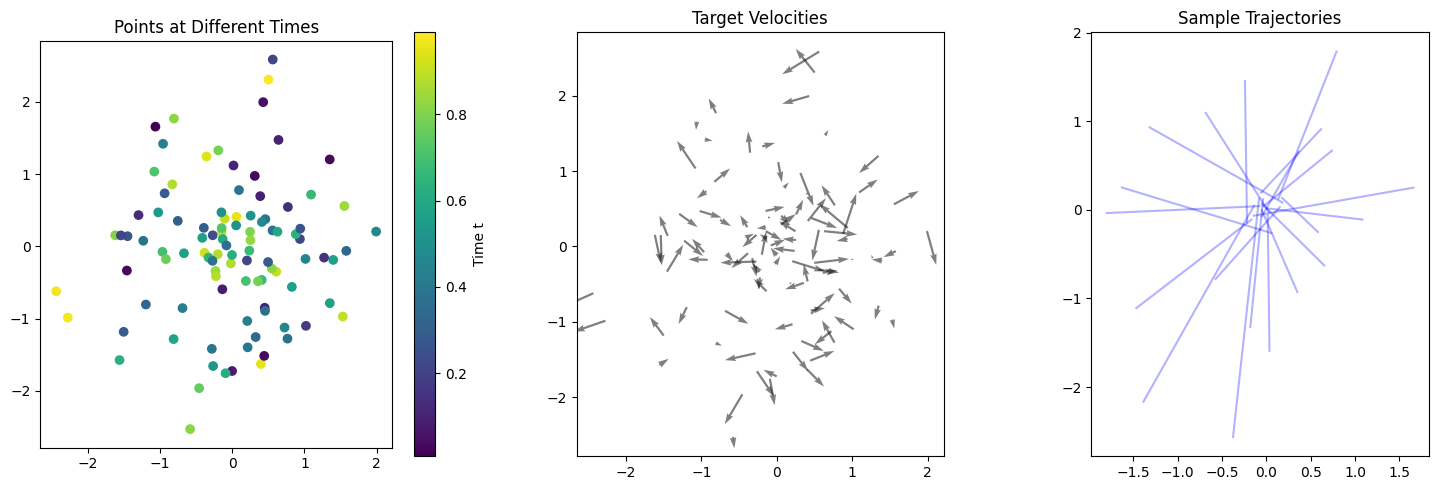

In [76]:
# viz code
points, times, velocities = generate_training_batch(100)

# Create figure with correct number of subplots
fig = plt.figure(figsize=(15, 5))
grid = plt.GridSpec(1, 3, figure=fig)

# Plot points colored by time
ax1 = fig.add_subplot(grid[0])
scatter = ax1.scatter(points[:, 0], points[:, 1], c=times, cmap='viridis')
plt.colorbar(scatter, label='Time t', ax=ax1)
ax1.set_title('Points at Different Times')
ax1.set_aspect('equal')

# Plot velocities
ax2 = fig.add_subplot(grid[1])
ax2.quiver(points[:, 0], points[:, 1], 
          velocities[:, 0], velocities[:, 1],
          alpha=0.5)
ax2.set_title('Target Velocities')
ax2.set_aspect('equal')

# Plot a few trajectories
ax3 = fig.add_subplot(grid[2])
for i in range(20):
    source = create_source_data(1)
    target = create_target_data(1)
    ts = torch.linspace(0, 1, 50).reshape(-1, 1)
    trajectory = source * (1 - ts) + target * ts
    ax3.plot(trajectory[:, 0], trajectory[:, 1], 'b-', alpha=0.3)
ax3.set_title('Sample Trajectories')
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

In the left picture above, point positions at early times are dark purple, and point positions at late times are yellow. Note how in the Sample Trajectories figure on the right, many of the trajectories *cross*.  The flow itself is not going to cross, but more on that later. 

### Training Loop

Now we can train our velocity prediction network. For each batch:
1. Generate training data as above
2. Pass points and times through our network
3. Compare predicted velocities with target velocities
4. Update network weights to reduce the difference

We'll use PyTorch Lightning to keep our code organized:


In [60]:
# PyTorch Lighting module defining how data and training are handled
class FlowMatcher(pl.LightningModule):
    def __init__(self, hidden_dim=64, batch_size=256):
        super().__init__()
        self.velocity_net = VelocityNet(hidden_dim)
        self.batch_size = batch_size
        self.training_losses = []  # Add this to store losses
        
    def train_dataloader(self):
        dataset = range(10000)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True,num_workers=12)
        
    def training_step(self, batch, batch_idx):
        points, times, target_velocities = generate_training_batch(self.batch_size)
        points = points.to(self.device)
        times = times.to(self.device)
        target_velocities = target_velocities.to(self.device)
        
        predicted_velocities = self.velocity_net(points, times)
        loss = F.mse_loss(predicted_velocities, target_velocities)
        
        # Store the loss for later visualization
        self.training_losses.append(loss.item())
        
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)  
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [61]:
# Train the model
torch.set_float32_matmul_precision('medium') # we could use 'high' but this will be faster
flow_matcher = FlowMatcher()
trainer = pl.Trainer(max_epochs=10000)
trainer.fit(flow_matcher)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type        | Params | Mode 
-----------------------------------------------------
0 | velocity_net | VelocityNet | 4.5 K  | train
-----------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                                  |…

`Trainer.fit` stopped: `max_epochs=10000` reached.


Let's visualize the flow we learned:

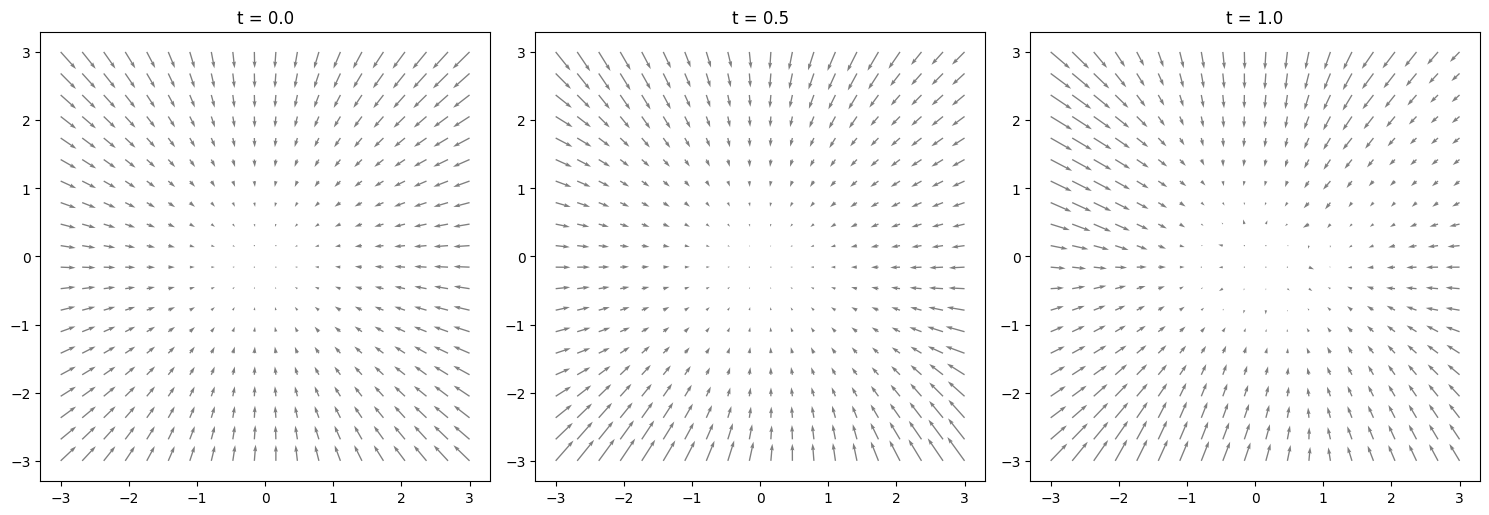

In [48]:
# code for visualize_learned_flow
@torch.no_grad()
def visualize_learned_flow(model, n_points=20):
    """Visualize the learned vector field at different times"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Create a grid of points - now with explicit indexing parameter
    x = torch.linspace(-3, 3, n_points)
    y = torch.linspace(-3, 3, n_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')  # Added indexing='ij'
    points = torch.stack([X.flatten(), Y.flatten()], dim=1)
    
    # Visualize at different times
    times = [0.0, 0.5, 1.0]
    for ax, t in zip(axes, times):
        t_batch = torch.ones(len(points)) * t
        velocities = model.velocity_net(points, t_batch)
        
        ax.quiver(points[:, 0], points[:, 1], 
                 velocities[:, 0], velocities[:, 1],
                 alpha=0.5)
        ax.set_title(f't = {t}')
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

visualize_learned_flow(flow_matcher)

And here's how the loss function developed with training:

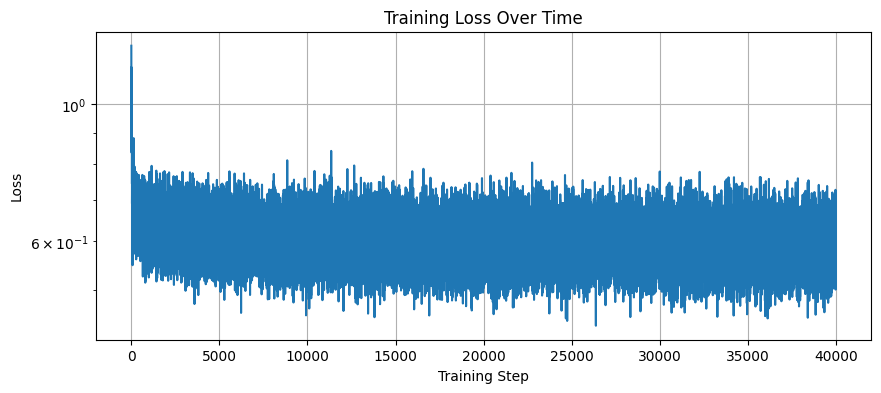

In [49]:
# Plot the loss
def plot_loss(flow_matcher):
    plt.figure(figsize=(10, 4))
    plt.plot(flow_matcher.training_losses)
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.yscale('log')  # Often helpful to view loss on log scale
    plt.title('Training Loss Over Time')
    plt.grid(True)
    plt.show()

plot_loss(flow_matcher) 

> Note: as with many generative models, the fact that the loss appears flat doesn't necessarily mean no training is occurring. To learn 'interesting' distributions you often need to train for very long times, with checking the progress by visualizating validation data. 

### Generating Samples: Following the Flow

Now that we have a trained model that predicts velocities, we can generate new samples by:
1. Starting with points from our source distribution (Gaussian)
2. Following the predicted velocities (using a numerical ODE solver)
3. This will transform our starting points into the target distribution (spiral)

The simplest numerical integration method is Euler's method:
- Take small time steps
- At each step, get the velocity from our network
- Move points in that direction
- Repeat until we reach t=1

In [50]:
def euler_sample(model, initial_points, n_steps=100):
   """Generate samples using Euler integration"""
   current_points = initial_points.clone()
   dt = 1.0 / n_steps
   
   with torch.no_grad():
       for i in range(n_steps):
           t = torch.ones(len(current_points)) * (i * dt)
           velocities = model.velocity_net(current_points, t)
           current_points = current_points + velocities * dt
           
   return current_points


In [51]:
# Generate some samples
n_samples = 1000
initial_points = create_source_data(n_samples)
transformed_points = euler_sample(flow_matcher, initial_points)
target_points = create_target_data(n_samples)

In [52]:
# Code for plot_distributions: visualize samples in source, output, and target distributions 

def plot_distributions(initial_points, transformed_points, target_points):
    # Find the global min and max of all data points
    all_points = np.concatenate((initial_points, transformed_points, target_points), axis=0)
    global_min = all_points.min(axis=0)
    global_max = all_points.max(axis=0)
    
    # Create the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (dist, title) in enumerate(zip([initial_points,transformed_points,target_points],
                                          ['Initial Distribution (Gaussian)','Transformed Distribution','True Target Distribution'])):
        axes[i].scatter(dist[:, 0], dist[:, 1], alpha=0.5,c='r')
        axes[i].set_title(title)
        axes[i].set_xlim(global_min[0], global_max[0])
        axes[i].set_ylim(global_min[1], global_max[1])
        axes[i].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()



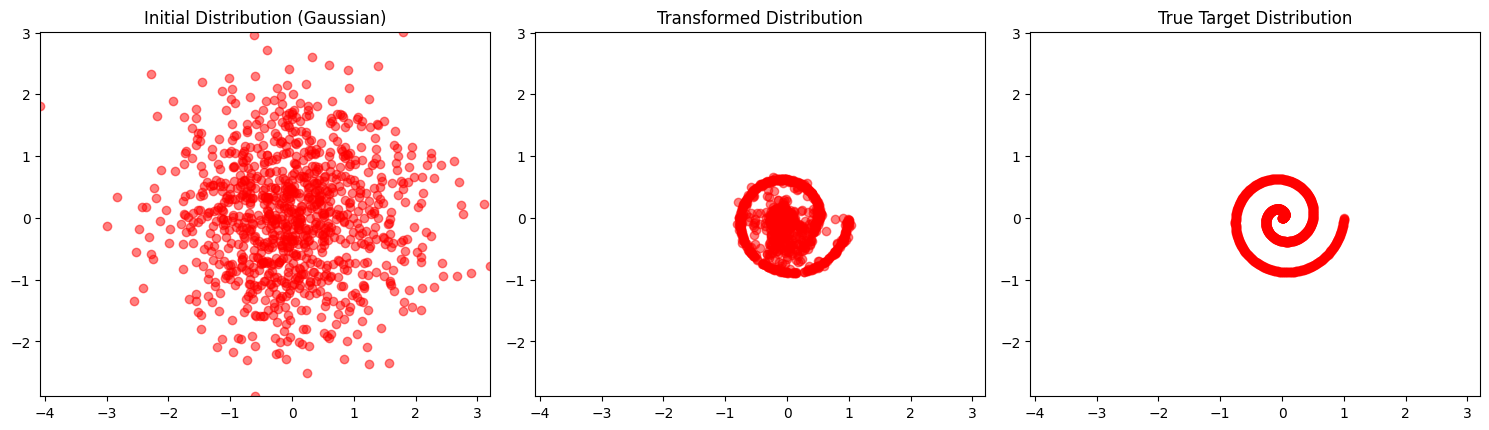

In [53]:
plot_distributions(initial_points, transformed_points, target_points)

### Let's Watch the Transformation!

We can also visualize how points move during the transformation process:


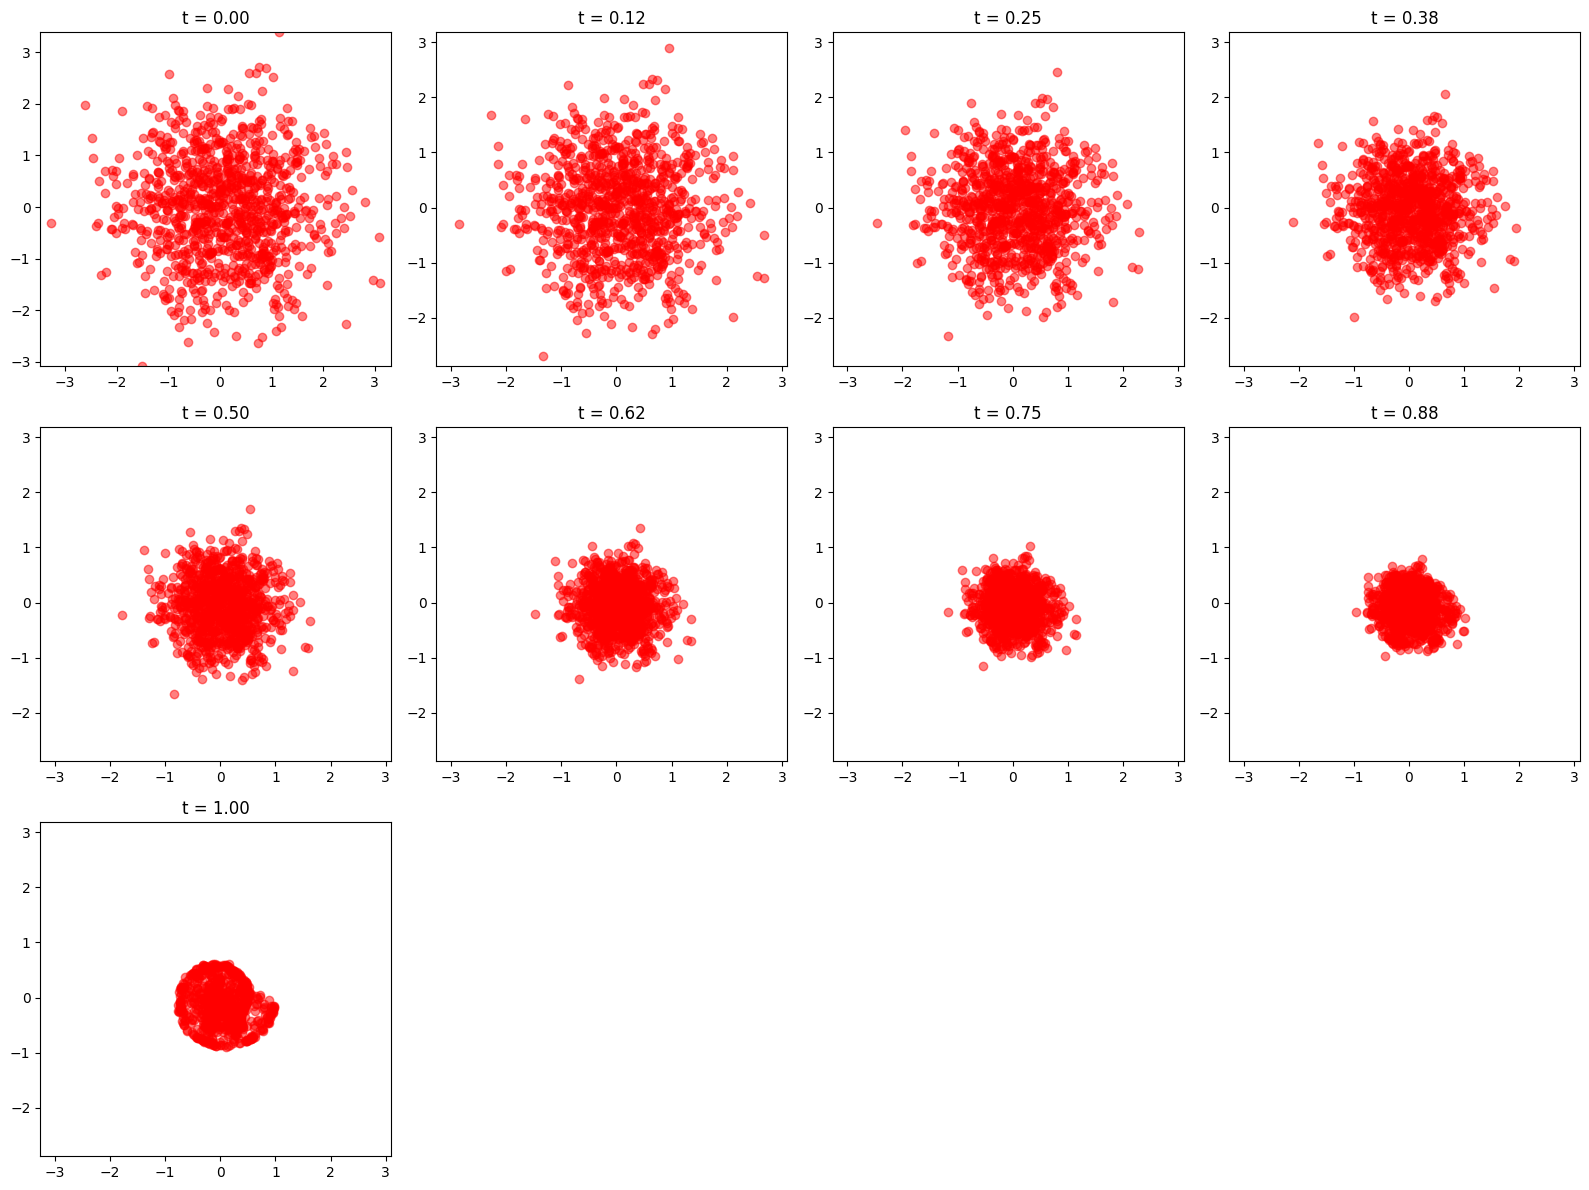

In [54]:
# code for visualize_flow_steps
def visualize_flow_steps(model, initial_points, n_steps=8):
    """Show the transformation at all steps"""
    current_points = initial_points.clone()
    dt = 1.0 / n_steps

    all_points = np.concatenate((initial_points, initial_points), axis=0)
    global_min = all_points.min(axis=0)
    global_max = all_points.max(axis=0)

    # Create a grid of subplots - now including space for initial state
    n_cols = 4
    n_rows = ((n_steps + 1) + n_cols - 1) // n_cols  # +1 for initial state
    plt.figure(figsize=(4*n_cols, 4*n_rows))

    
    with torch.no_grad():
        # Plot initial state
        plt.subplot(n_rows, n_cols, 1)
        plt.scatter(current_points[:, 0], current_points[:, 1], alpha=0.5,c='r')
        plt.title(f't = 0.00')
        plt.axis('equal')
        if global_min is not None and global_max is not None:
            plt.xlim(global_min[0], global_max[0])
            plt.ylim(global_min[1], global_max[1])
        
        # Run and plot each step
        for i in range(n_steps):
            t = torch.ones(len(current_points)) * (i * dt)
            velocities = model.velocity_net(current_points, t)
            current_points = current_points + velocities * dt
            
            if (i + 2) <= n_rows * n_cols:  # Make sure we don't exceed subplot count
                plt.subplot(n_rows, n_cols, i + 2)  # +2 because we already plotted initial state
                plt.scatter(current_points[:, 0], current_points[:, 1], alpha=0.5,c='r')
                plt.title(f't = {(i+1)*dt:.2f}')
                plt.axis('equal')
                if global_min is not None and global_max is not None:
                    plt.xlim(global_min[0], global_max[0])
                    plt.ylim(global_min[1], global_max[1])
    
    plt.tight_layout()
    plt.show()
    
# Visualize the transformation process
n_samples = 1000
initial_points = create_source_data(n_samples)
visualize_flow_steps(flow_matcher, create_source_data(n_samples)) 


Well... that's maybe ok, but we could hope to do better.  Here are some improvements we could make:

1. Give the neural network more expressive power (via more layers, more neurons per layer)
2. Train longer?  (Maybe, unless the loss curve flattens out early on)
3. Upgrade the numerical integrator (from Euler to 4th order Runge-Kutta)


Let's try those:

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | velocity_net | Sequential | 50.3 K | train
----------------------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/shawley/envs/blog/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/shawley/envs/blog/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (16) is 

Training: |                                                                                                  |…

`Trainer.fit` stopped: `max_epochs=10000` reached.


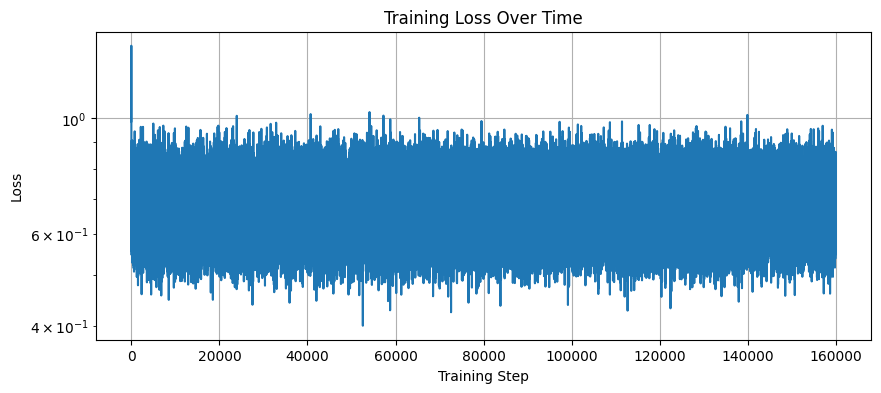

In [34]:
# Code for Upgraded NN curve-fitter
class FlowMatcher(pl.LightningModule):
    def __init__(self, hidden_dim=128, batch_size=128):  # Increased hidden_dim
        super().__init__()
        self.velocity_net = nn.Sequential(
            nn.Linear(2 + 1, hidden_dim),
            nn.SiLU(),  # Using SiLU (also known as swish) instead of ReLU
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),                         # this is already more layers than before
            nn.Linear(hidden_dim, hidden_dim), 
            nn.SiLU(),                         # heck let's go nuts with the layers
            nn.Linear(hidden_dim, 2)
        )
        self.batch_size = batch_size
        self.training_losses = []
        
    def train_dataloader(self):
        dataset = range(2000)  # More samples per epoch
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
    def training_step(self, batch, batch_idx):
        points, times, target_velocities = generate_training_batch(self.batch_size)
        points = points.to(self.device)
        times = times.to(self.device)
        target_velocities = target_velocities.to(self.device)
        
        predicted_velocities = self(points, times)
        loss = F.mse_loss(predicted_velocities, target_velocities)
        
        self.training_losses.append(loss.item())
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)  
        return loss
    
    def forward(self, x, t):
        xt = torch.cat([x, t.reshape(-1, 1)], dim=1)
        return self.velocity_net(xt)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "train_loss"
        }

# Train the model
flow_matcher = FlowMatcher()
trainer = pl.Trainer(max_epochs=10000)  # More epochs
trainer.fit(flow_matcher)
plot_loss(flow_matcher) 

In [42]:
# Let's also use a better sampling method for inference
def rk4_sample(model, initial_points, n_steps=100):
    """Generate samples using 4th-order Runge-Kutta integration"""
    current_points = initial_points.clone()
    dt = 1.0 / n_steps
    
    def get_velocity(points, t):
        t_batch = torch.ones(len(points)) * t
        return model(points, t_batch)
    
    with torch.no_grad():
        for i in range(n_steps):
            t = i * dt
            
            # RK4 integration steps
            k1 = get_velocity(current_points, t)
            k2 = get_velocity(current_points + k1 * dt/2, t + dt/2)
            k3 = get_velocity(current_points + k2 * dt/2, t + dt/2)
            k4 = get_velocity(current_points + k3 * dt, t + dt)
            
            # Update points
            current_points = current_points + (k1 + 2*k2 + 2*k3 + k4) * dt/6
            
    return current_points

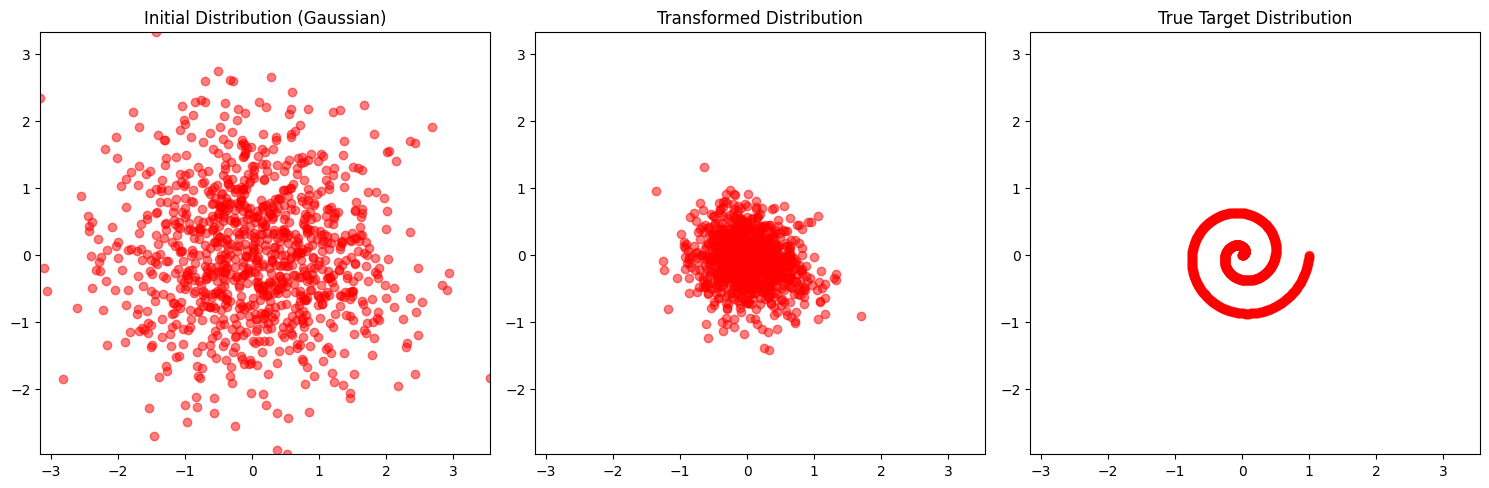

In [43]:
n_samples = 1000
initial_points = create_source_data(n_samples)
transformed_points = rk4_sample(flow_matcher, initial_points)
target_points = create_target_data(n_samples)
plot_distributions(initial_points, transformed_points, target_points)


We could still hope to do better.   Looking back, our initial estimate of straight-line paths wasn't a great choice. Many of those paths would cross each other, which is not strictly allowed in a "flow". 

# Reflections and Commentary 
## My reflections:
Ok, I now think I understand why they're called flow models. each point moves to a new location, the velocity at that location determines where the point should go next. so the model is learning this velocity field. 

A problem I foresee is that we only know the initial and final *position* distributions, we know nothing about the velocity field yet we are training to produce a target velocity field.  so far we have been estimating that by just assuming some kind of linear interpolation between initial and target points without any consideration of which points should be paired together.  this means we get many trajectories that cross, but crossing trajectories means that the flow field is not defined, because the transformation of one velocity per location would be broken -- crossing lines implies the velocity at a location is not unique. 

So... what are we doing, then?  We're just hoping, that after randomly collecting thousands and thousands of pairs of (input, target) points, that the the net behavior of some kind of "net" average flow will... relax out of this process? 

## Claude 3.5 Sonnet's response to that: 
*This is an excellent insight! You've hit upon one of the core conceptual challenges of flow matching. Let me expand on your observation:*
### The Flow Matching Paradox

As you've pointed out, there's something subtle and potentially problematic in our approach:

1. A proper flow field should have exactly one velocity vector at each point in space
2. Our training process generates data by naively pairing points and creating straight-line paths
3. These paths frequently cross, which as you note, is physically impossible for a true flow field
4. Yet somehow, this process can still work (when we do it right!)

The resolution to this paradox lies in what the model learns:
- Instead of learning any specific point-to-point mappings
- It learns a "consensus" velocity field that captures the aggregate behavior
- This field represents the most probable flow direction at each point
- The actual learned field won't exactly follow our training trajectories

Think of it like learning traffic patterns:
- Individual cars might take different routes between A and B
- Some routes might cross
- But the learned "flow" represents the dominant direction of motion at each point
- This aggregate flow field can still transform the distribution correctly

This is why flow matching is about transforming *distributions*, not individual points. The learned velocity field might not exactly match any of our training trajectories, but it captures the statistical flow needed to transform one distribution into another.

Let's visualize this by plotting:
1. Our naive training trajectories (with crossings)
2. The actual learned flow field
3. The paths points take when following the learned field

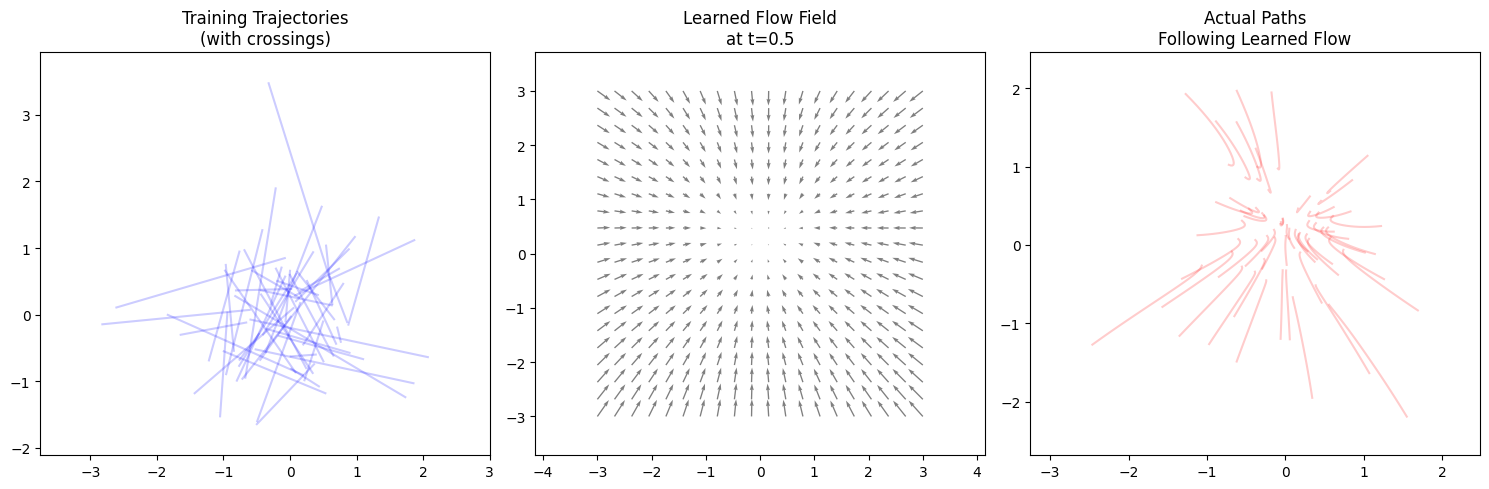

In [26]:
def plot_training_trajectories_vs_learned_flow():
   """Compare training trajectories with learned flow field"""
   plt.figure(figsize=(15, 5))
   
   # 1. Plot some training trajectories
   plt.subplot(131)
   n_trajs = 50  # Number of trajectories to show
   source = create_gaussian_data(n_trajs)
   target = create_square_data(n_trajs)
   
   # Plot straight-line trajectories from source to target
   times = torch.linspace(0, 1, 20)
   for i in range(n_trajs):
       traj = source[i:i+1] * (1 - times.reshape(-1, 1)) + target[i:i+1] * times.reshape(-1, 1)
       plt.plot(traj[:, 0], traj[:, 1], 'b-', alpha=0.2)
   plt.title('Training Trajectories\n(with crossings)')
   plt.axis('equal')
   
   # 2. Plot learned flow field
   plt.subplot(132)
   x = torch.linspace(-3, 3, 20)
   y = torch.linspace(-3, 3, 20)
   X, Y = torch.meshgrid(x, y, indexing='ij')
   points = torch.stack([X.flatten(), Y.flatten()], dim=1)
   
   with torch.no_grad():
       t = torch.ones(len(points)) * 0.5  # Show flow field at t=0.5
       velocities = flow_matcher(points, t)
   
   plt.quiver(points[:, 0], points[:, 1], 
             velocities[:, 0], velocities[:, 1],
             alpha=0.5)
   plt.title('Learned Flow Field\nat t=0.5')
   plt.axis('equal')
   
   # 3. Plot actual paths taken using learned flow
   plt.subplot(133)
   source = create_gaussian_data(n_trajs)
   
   # Use RK4 to follow the learned flow
   paths = []
   current_points = source.clone()
   n_steps = 20
   dt = 1.0 / n_steps
   
   with torch.no_grad():
       for i in range(n_steps):
           paths.append(current_points.clone())
           
           # RK4 step
           t = torch.ones(len(current_points)) * (i * dt)
           k1 = flow_matcher(current_points, t)
           k2 = flow_matcher(current_points + k1 * dt/2, t + dt/2)
           k3 = flow_matcher(current_points + k2 * dt/2, t + dt/2)
           k4 = flow_matcher(current_points + k3 * dt, t + dt)
           
           current_points = current_points + (k1 + 2*k2 + 2*k3 + k4) * dt/6
   
   paths = torch.stack(paths)
   
   # Plot the actual paths
   for i in range(n_trajs):
       traj = paths[:, i, :]
       plt.plot(traj[:, 0], traj[:, 1], 'r-', alpha=0.2)
   plt.title('Actual Paths\nFollowing Learned Flow')
   plt.axis('equal')
   
   plt.tight_layout()
   plt.show()

# Run the visualization
plot_training_trajectories_vs_learned_flow()


Notice the differences:
1. Left: Training data uses simple straight lines (with many crossings)
2. Middle: The learned flow field is smooth and continuous
3. Right: Actual paths following the flow field are more natural

The model has learned a "compromise" flow field that:
- Maintains one velocity per location
- Captures the overall transformation we want
- May not follow any individual training trajectory exactly

---
# Next Time: Rectified Flow Models
All the trajectory-crossing that happens with naive flow matching makes it harder for the model to learn.  ['Rectified' Flow](https://arxiv.org/abs/2209.03003) models are designed to provide a better guess of the trajectories, namely without crossing ...so that things can can go better. We'll cover these in a later lesson:
<div> 
    <img src="https://www.cs.utexas.edu/~lqiang/rectflow/html/_images/flow1.gif" width="30%">
    <img src="https://www.cs.utexas.edu/~lqiang/rectflow/html/_images/flow0.gif" width="30%">
    <img src="https://www.cs.utexas.edu/~lqiang/rectflow/html/_images/flow2.gif" width="30%"><br>
    <center>Left: Naive interpolation with crossing trajectories.  Center: Crossing trajectories "rectified" to prevent crossing. Right: Curved/angled flows are straightened to enable fast inference with fewer steps.
        <br><i>(Image source: Rectified Flow paper)</i></center>
</div>




...or as I'll describe it: given two (linear) trajectories for points moving from source to target: if the trjectories would cross, then *swap the endpoints*.  It's a pretty simple idea, however a naive implementation (where you check all the pairs of trajectories for crossings) is so suuuuuuuper slow (i.e. $\mathcal{O}(N^2)$) *per batch*) that it would be practically useless, so you have to be clever: What you do can instead is you *penalize* the model for bringing points very close together, i.e. you add a term to the loss function that increases the loss when two points are really close. Even that can be slow... Anyway, more later. 